In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import pickle
from collections import Counter
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (
    accuracy_score, confusion_matrix, f1_score,
    roc_curve, precision_recall_curve, average_precision_score, roc_auc_score
)
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 固定所有随机种子
np.random.seed(42)
tf.random.set_seed(42)

# 配置核心路径
BASE_PATH = r"D:\Users\26097\Desktop\homework"
os.makedirs(BASE_PATH, exist_ok=True)  # 确保目录存在

# 创建临时目录（用于KNN GridSearchCV缓存）
os.makedirs("D:/joblib_temp", exist_ok=True)
os.environ["JOBLIB_TEMP_FOLDER"] = "D:/joblib_temp"

# 设置中文字体
plt.rcParams["font.family"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False

D:\jupter\Lib\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# 1. 加载Olivetti原始数据
faces = fetch_olivetti_faces(shuffle=True, random_state=42)
X = faces.data  
y = faces.target  

# 2. 均衡拆分数据集（训练集280+验证集40+测试集80）
# 第一步：拆分训练+验证 与 测试集
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=80, random_state=42, stratify=y
)
# 第二步：拆分训练集与验证集
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=40, random_state=42, stratify=y_train_val
)

# 3. 数据格式转换
# KNN：展平为一维特征（64×64=4096维）
x_train_flat = X_train.reshape(-1, 64*64)
x_val_flat = X_val.reshape(-1, 64*64)
x_test_flat = X_test.reshape(-1, 64*64)

# CNN：添加通道维度（(样本数, 64, 64, 1)）
x_train_cnn = X_train.reshape(-1, 64, 64, 1).astype(np.float32)
x_val_cnn = X_val.reshape(-1, 64, 64, 1).astype(np.float32)
x_test_cnn = X_test.reshape(-1, 64, 64, 1).astype(np.float32)

# 4. 保存预处理数据
np.savez(
    f"{BASE_PATH}/olivetti_correct_preprocessed.npz",
    # KNN数据
    x_train_flat=x_train_flat, x_val_flat=x_val_flat, x_test_flat=x_test_flat,
    # CNN数据
    x_train_cnn=x_train_cnn, x_val_cnn=x_val_cnn, x_test_cnn=x_test_cnn,
    # 标签
    y_train=y_train, y_val=y_val, y_test=y_test
)

print("数据预处理完成，各部分形状：")
print(f"KNN训练集：{x_train_flat.shape} | CNN训练集：{x_train_cnn.shape}")
print(f"验证集样本数：{x_val_flat.shape[0]} | 测试集样本数：{x_test_flat.shape[0]}")
print(f"像素值范围：{x_train_cnn.min():.3f}-{x_train_cnn.max():.3f}")

数据预处理完成，各部分形状：
KNN训练集：(280, 4096) | CNN训练集：(280, 64, 64, 1)
验证集样本数：40 | 测试集样本数：80
像素值范围：0.004-1.000（正确应为0-1）


数据有效性检查：
1. 训练集图像类型：float32（应为float32）
   标签类型：int32（应为int64）
2. 训练集缺失值：False | 测试集缺失值：False
3. 训练集像素范围：[0.004, 1.000]（正确应为0-1）
4. 训练集标签覆盖：True（应覆盖0-39）
5. 训练集全黑图像：0 | 测试集：0


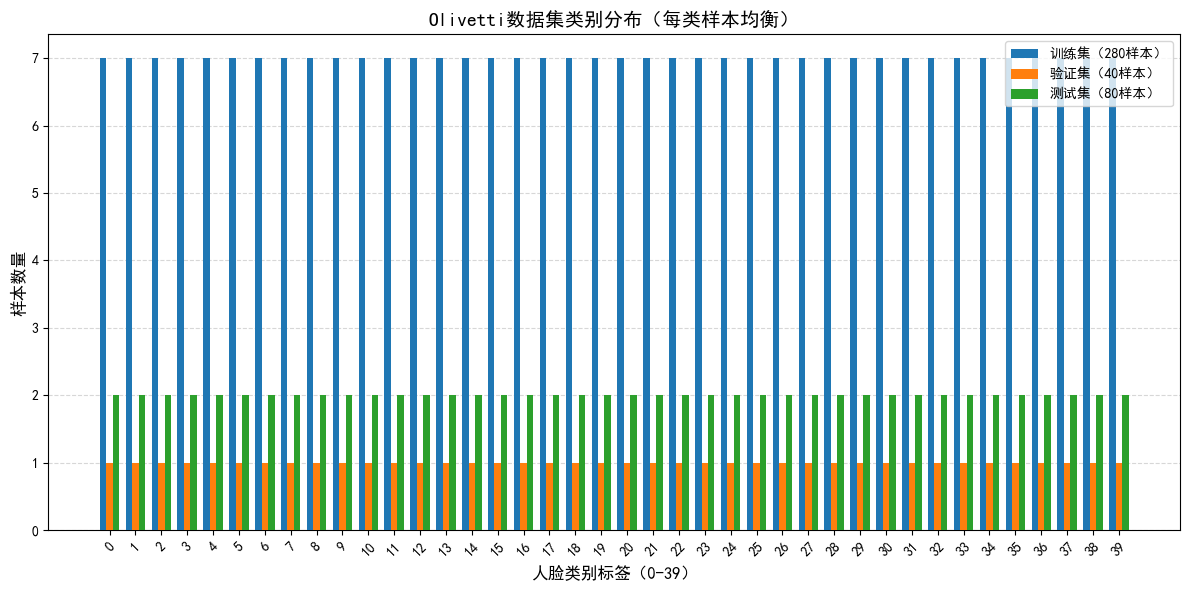

In [3]:
# 加载预处理数据
with np.load(f"{BASE_PATH}/olivetti_correct_preprocessed.npz", allow_pickle=True) as data:
    x_train_cnn = data["x_train_cnn"]
    x_test_cnn = data["x_test_cnn"]
    y_train = data["y_train"]
    y_val = data["y_val"]
    y_test = data["y_test"]

# 类型检查
print(f"训练集图像类型：{x_train_cnn.dtype}")
print(f"标签类型：{y_train.dtype}")
# 缺失值检查
print(f"训练集缺失值：{np.isnan(x_train_cnn).any()} | 测试集缺失值：{np.isnan(x_test_cnn).any()}")
# 像素范围检查
print(f"训练集像素范围：[{x_train_cnn.min():.3f}, {x_train_cnn.max():.3f}]")
# 标签完整性检查
train_labels = np.unique(y_train)
print(f"训练集标签覆盖：{np.array_equal(sorted(train_labels), np.arange(40))}")
# 异常样本检查（全黑图像）
def count_black_imgs(data):
    return np.sum(data.reshape(data.shape[0], -1).sum(axis=1) == 0)
print(f"训练集全黑图像：{count_black_imgs(x_train_cnn)} | 测试集：{count_black_imgs(x_test_cnn)}")
print("="*50)

# 类别分布可视化
train_dist = np.bincount(y_train)
val_dist = np.bincount(y_val)
test_dist = np.bincount(y_test)

plt.figure(figsize=(12, 6))
plt.bar(range(40), train_dist, width=0.25, label="训练集（280样本）", color="#1f77b4", zorder=3)
plt.bar(np.arange(40)+0.25, val_dist, width=0.25, label="验证集（40样本）", color="#ff7f0e", zorder=3)
plt.bar(np.arange(40)+0.5, test_dist, width=0.25, label="测试集（80样本）", color="#2ca02c", zorder=3)

plt.title("Olivetti数据集类别分布（每类样本均衡）", fontsize=14)
plt.xlabel("人脸类别标签（0-39）", fontsize=12)
plt.ylabel("样本数量", fontsize=12)
plt.xticks(np.arange(40)+0.25, range(40), rotation=45)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5, zorder=0)
plt.tight_layout()
plt.savefig(f"{BASE_PATH}/olivetti类别分布.png", dpi=300, bbox_inches="tight")
plt.show()

In [4]:
with np.load(f"{BASE_PATH}/olivetti_correct_preprocessed.npz", allow_pickle=True) as data:
    x_train_flat = data["x_train_flat"]
    x_val_flat = data["x_val_flat"]
    x_test_flat = data["x_test_flat"]
    y_train = data["y_train"]
    y_val = data["y_val"]
    y_test = data["y_test"]

# 训练Dummy模型
dummy = DummyClassifier(strategy="most_frequent", random_state=42)
dummy.fit(x_train_flat, y_train)

# 评估指标
dummy_train_acc = accuracy_score(y_train, dummy.predict(x_train_flat))
dummy_val_acc = accuracy_score(y_val, dummy.predict(x_val_flat))
dummy_test_acc = accuracy_score(y_test, dummy.predict(x_test_flat))
dummy_f1 = f1_score(y_test, dummy.predict(x_test_flat), average="macro")

print("Dummy基准模型结果：")
print(f"训练准确率：{dummy_train_acc:.1%} | 验证准确率：{dummy_val_acc:.1%}")
print(f"测试准确率：{dummy_test_acc:.1%} | 宏平均F1：{dummy_f1:.2f}")

# 保存结果
np.savez(
    f"{BASE_PATH}/dummy_olivetti_results.npz",
    train_acc=dummy_train_acc, val_acc=dummy_val_acc,
    test_acc=dummy_test_acc, macro_f1=dummy_f1
)

Dummy基准模型结果：
训练准确率：2.5% | 验证准确率：2.5%
测试准确率：2.5% | 宏平均F1：0.00


In [5]:
with np.load(f"{BASE_PATH}/olivetti_correct_preprocessed.npz", allow_pickle=True) as data:
    x_train_flat = data["x_train_flat"]
    x_val_flat = data["x_val_flat"]
    x_test_flat = data["x_test_flat"]
    y_train = data["y_train"]
    y_val = data["y_val"]
    y_test = data["y_test"]

# 1. KNN超参调优
param_grid = {
    "n_neighbors": [3, 5, 7, 9],
    "metric": ["euclidean", "cosine"],
    "algorithm": ["ball_tree"]  # 加速高维数据搜索
}

# 5折交叉验证
grid_search = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=1,
    verbose=1
)
grid_search.fit(x_train_flat, y_train)

# 2. 最优KNN模型评估
best_knn = grid_search.best_estimator_
print(f"\nKNN最优超参数：{grid_search.best_params_}")
print(f"交叉验证最优准确率：{grid_search.best_score_:.4f}")

# 关键指标计算
train_acc_knn = best_knn.score(x_train_flat, y_train)
val_acc_knn = best_knn.score(x_val_flat, y_val)
test_acc_knn = best_knn.score(x_test_flat, y_test)

# 推理时间
start_time = time.time()
y_pred_knn = best_knn.predict(x_test_flat)
knn_inference_time = time.time() - start_time

# 其他评估指标
cm_knn = confusion_matrix(y_test, y_pred_knn)
knn_f1 = f1_score(y_test, y_pred_knn, average="macro")
y_proba_knn = best_knn.predict_proba(x_test_flat)

print(f"训练准确率：{train_acc_knn:.4f} | 验证准确率：{val_acc_knn:.4f}")
print(f"测试准确率：{test_acc_knn:.4f} | 宏平均F1：{knn_f1:.4f}")
print(f"测试集推理时间：{knn_inference_time:.2f}秒")

# 3. 保存模型和结果
with open(f"{BASE_PATH}/best_knn_olivetti.pkl", "wb") as f:
    pickle.dump(best_knn, f)

np.savez(
    f"{BASE_PATH}/knn_results_olivetti.npz",
    train_acc=train_acc_knn, val_acc=val_acc_knn, test_acc=test_acc_knn,
    confusion_matrix=cm_knn, y_pred=y_pred_knn, y_proba=y_proba_knn,
    macro_f1=knn_f1, inference_time=knn_inference_time
)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


D:\jupter\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
20 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "D:\jupter\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\jupter\Lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\jupter\Lib\site-packages\sklearn\neighbors\_classification.py", line 233, in fit
    return self._fit(X, y)
           ^^^^^^^^^^^^^^^
  File "D:\jupter\


KNN最优超参数：{'algorithm': 'ball_tree', 'metric': 'euclidean', 'n_neighbors': 3}
交叉验证最优准确率：0.7750

KNN模型最终评估：
训练准确率：0.9607 | 验证准确率：0.8500
测试准确率：0.8375 | 宏平均F1：0.8210
测试集推理时间：0.12秒


In [6]:
with np.load(f"{BASE_PATH}/olivetti_correct_preprocessed.npz", allow_pickle=True) as data:
    x_train_cnn = data["x_train_cnn"]
    y_train = data["y_train"]

# 1. 定义CNN模型
def build_cnn(learning_rate=0.001, filters1=32, filters2=64, dropout_rate=0.2):
    model = Sequential([
        Conv2D(filters1, (3, 3), activation='relu', input_shape=(64, 64, 1)),
        MaxPooling2D((2, 2)),
        Conv2D(filters2, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(dropout_rate, seed=42),
        Dense(40, activation='softmax')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

# 2. 超参搜索范围
param_grid = {
    "learning_rate": [0.001, 0.002],
    "filters1": [32, 64],
    "dropout_rate": [0.2, 0.3]
}

# 3. 5折交叉验证
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
best_accuracy = 0.0
best_params = None
early_stopping = EarlyStopping(
    monitor='val_accuracy', patience=4, restore_best_weights=True, verbose=0
)

# 超参搜索循环
for lr in param_grid["learning_rate"]:
    for f1 in param_grid["filters1"]:
        for dr in param_grid["dropout_rate"]:
            fold_accuracies = []
            
            for fold, (train_idx, val_idx) in enumerate(skf.split(x_train_cnn, y_train), 1):
                x_fold_train, x_fold_val = x_train_cnn[train_idx], x_train_cnn[val_idx]
                y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]
                
                model = build_cnn(learning_rate=lr, filters1=f1, filters2=64, dropout_rate=dr)
                model.fit(
                    x_fold_train, y_fold_train,
                    batch_size=8, epochs=20,
                    validation_data=(x_fold_val, y_fold_val),
                    callbacks=[early_stopping], verbose=0
                )
                
                val_loss, val_acc = model.evaluate(x_fold_val, y_fold_val, verbose=0)
                fold_accuracies.append(val_acc)
            
            avg_acc = np.mean(fold_accuracies)
            
            if avg_acc > best_accuracy:
                best_accuracy = avg_acc
                best_params = {
                    "learning_rate": lr, "filters1": f1,
                    "dropout_rate": dr, "filters2": 64
                }

# 4. 保存最优超参
np.savez(
    f"{BASE_PATH}/cnn_olivetti_best_hyperparams.npz",
    best_lr=best_params["learning_rate"],
    best_filters1=best_params["filters1"],
    best_filters2=best_params["filters2"],
    best_dropout=best_params["dropout_rate"],
    best_avg_acc=best_accuracy
)

print(f"\n最优超参：{best_params}")
print(f"交叉验证最优平均准确率：{best_accuracy:.4f}")


测试超参：学习率=0.001, 第一层卷积核=32, Dropout=0.2




  第1折准确率：0.8393
  第2折准确率：0.8393
  第3折准确率：0.8929
  第4折准确率：0.8929
  第5折准确率：0.9107
  平均准确率：0.8750

测试超参：学习率=0.001, 第一层卷积核=32, Dropout=0.3
  第1折准确率：0.8750
  第2折准确率：0.8393
  第3折准确率：0.8393
  第4折准确率：0.8929
  第5折准确率：0.9464
  平均准确率：0.8786

测试超参：学习率=0.001, 第一层卷积核=64, Dropout=0.2
  第1折准确率：0.8571
  第2折准确率：0.9107
  第3折准确率：0.8929
  第4折准确率：0.8750
  第5折准确率：0.0179
  平均准确率：0.7107

测试超参：学习率=0.001, 第一层卷积核=64, Dropout=0.3
  第1折准确率：0.0357
  第2折准确率：0.8393
  第3折准确率：0.9107
  第4折准确率：0.8929
  第5折准确率：0.8571
  平均准确率：0.7071

测试超参：学习率=0.002, 第一层卷积核=32, Dropout=0.2
  第1折准确率：0.8750
  第2折准确率：0.8571
  第3折准确率：0.8393
  第4折准确率：0.9107
  第5折准确率：0.9286
  平均准确率：0.8821

测试超参：学习率=0.002, 第一层卷积核=32, Dropout=0.3
  第1折准确率：0.9107
  第2折准确率：0.8393
  第3折准确率：0.0179
  第4折准确率：0.8393
  第5折准确率：0.8929
  平均准确率：0.7000

测试超参：学习率=0.002, 第一层卷积核=64, Dropout=0.2
  第1折准确率：0.0357
  第2折准确率：0.0179
  第3折准确率：0.8393
  第4折准确率：0.8571
  第5折准确率：0.0357
  平均准确率：0.3571

测试超参：学习率=0.002, 第一层卷积核=64, Dropout=0.3
  第1折准确率：0.

In [11]:
with np.load(f"{BASE_PATH}/olivetti_correct_preprocessed.npz", allow_pickle=True) as data:
    x_train_cnn = data["x_train_cnn"]
    x_val_cnn = data["x_val_cnn"]
    x_test_cnn = data["x_test_cnn"]
    y_train = data["y_train"]
    y_val = data["y_val"]
    y_test = data["y_test"]

with np.load(f"{BASE_PATH}/cnn_olivetti_best_hyperparams.npz", allow_pickle=True) as hyper:
    best_lr = float(hyper["best_lr"])
    best_filters1 = int(hyper["best_filters1"])
    best_filters2 = int(hyper["best_filters2"])
    best_dropout = float(hyper["best_dropout"])
    best_avg_acc = float(hyper["best_avg_acc"])

# 1. 构建CNN模型
def build_final_cnn(learning_rate, dropout_rate):
    model = Sequential([
        Conv2D(best_filters1, (3, 3), activation='relu', input_shape=(64, 64, 1)),
        MaxPooling2D((2, 2)),
        Conv2D(best_filters2, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(dropout_rate, seed=42),
        Dense(40, activation='softmax')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

# 2. 训练配置
early_stopping_final = EarlyStopping(
    monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1
)

# 3. 训练最终模型
print(f"最优超参：学习率={best_lr}, Dropout={best_dropout}, 卷积核=({best_filters1}, {best_filters2})")
print(f"交叉验证最优准确率：{best_avg_acc:.4f}")

final_model = build_final_cnn(learning_rate=best_lr, dropout_rate=best_dropout)
final_model.summary()

history_final = final_model.fit(
    x_train_cnn, y_train,
    batch_size=8, epochs=20,
    validation_data=(x_val_cnn, y_val),
    callbacks=[early_stopping_final],
    verbose=1
)

# 4. 模型评估
train_loss, train_acc = final_model.evaluate(x_train_cnn, y_train, verbose=1)
val_loss, val_acc = final_model.evaluate(x_val_cnn, y_val, verbose=1)
test_loss, test_acc = final_model.evaluate(x_test_cnn, y_test, verbose=1)

y_pred_proba = final_model.predict(x_test_cnn, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)
cnn_f1 = f1_score(y_test, y_pred, average="macro")
cm_cnn = confusion_matrix(y_test, y_pred)

# 推理时间
start_time = time.time()
_ = final_model.predict(x_test_cnn, verbose=0)
cnn_inference_time = time.time() - start_time

# 打印结果
print(f"\nCNN最终模型评估：")
print(f"训练准确率：{train_acc:.4f} | 验证准确率：{val_acc:.4f}")
print(f"测试准确率：{test_acc:.4f} | 宏平均F1：{cnn_f1:.4f}")
print(f"测试集推理时间：{cnn_inference_time:.2f}秒")

# 5. 保存模型和完整结果
final_model.save(f"{BASE_PATH}/cnn_olivetti_final_model_working.h5")
np.savez(
    f"{BASE_PATH}/olivetti_cnn_final_complete_results.npz",
    hyperparams={
        "learning_rate": best_lr, "filters1": best_filters1,
        "filters2": best_filters2, "dropout_rate": best_dropout,
        "cv_best_avg_acc": best_avg_acc
    },
    training_history=history_final.history,
    test_results={
        "test_acc": test_acc, "test_loss": test_loss,
        "confusion_matrix": cm_cnn, "y_pred": y_pred,
        "y_pred_proba": y_pred_proba, "macro_f1": cnn_f1,
        "inference_time": cnn_inference_time
    }
)

最优超参：学习率=0.002, Dropout=0.2, 卷积核=(32, 64)
交叉验证最优准确率：0.8821
Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_86 (Conv2D)          (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d_86 (MaxPooli  (None, 31, 31, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_87 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_87 (MaxPooli  (None, 14, 14, 64)        0         
 ng2D)                                                           
                                                                 
 flatten_43 (Flatten)        (None, 12544)             0         
                                                            

D:\jupter\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


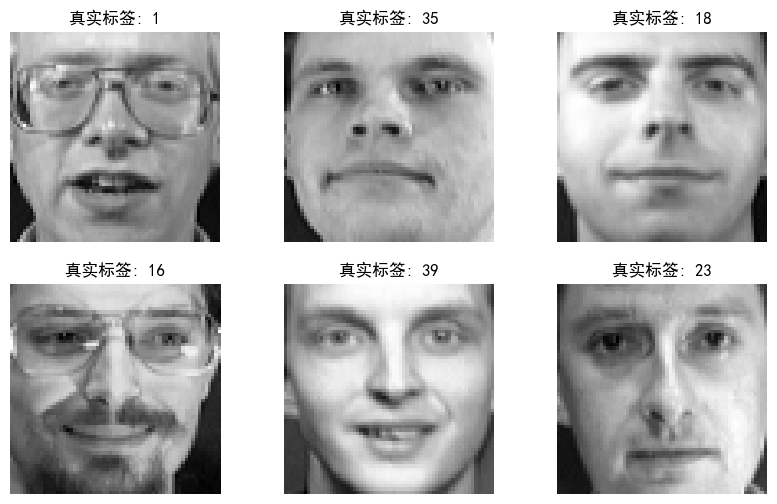

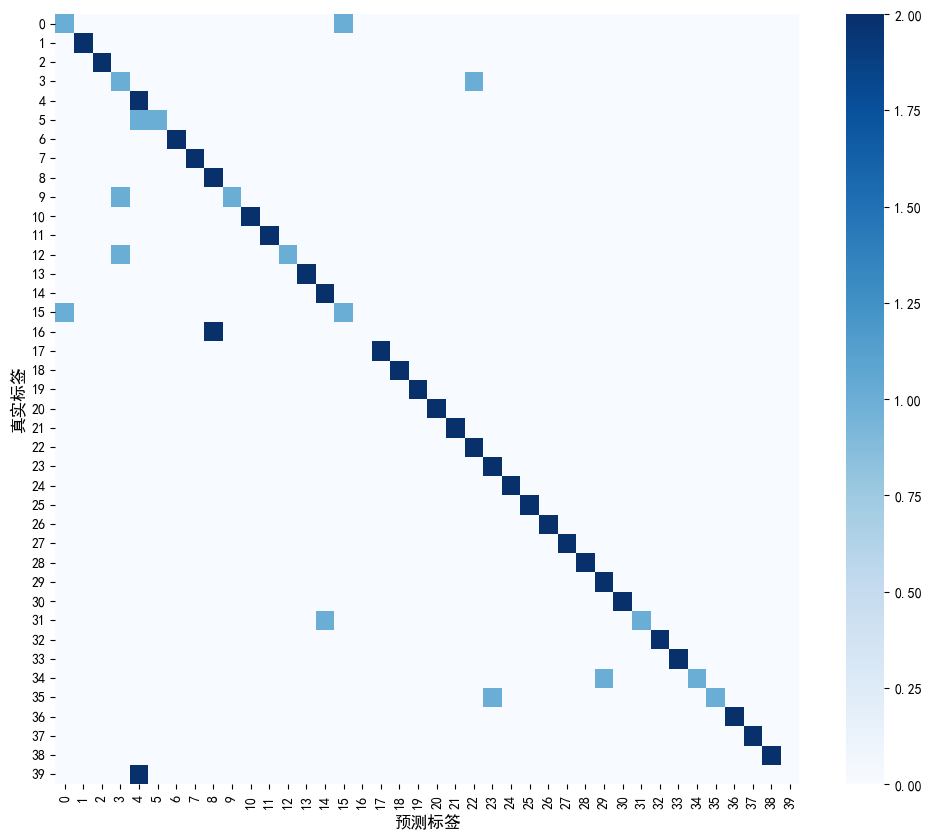

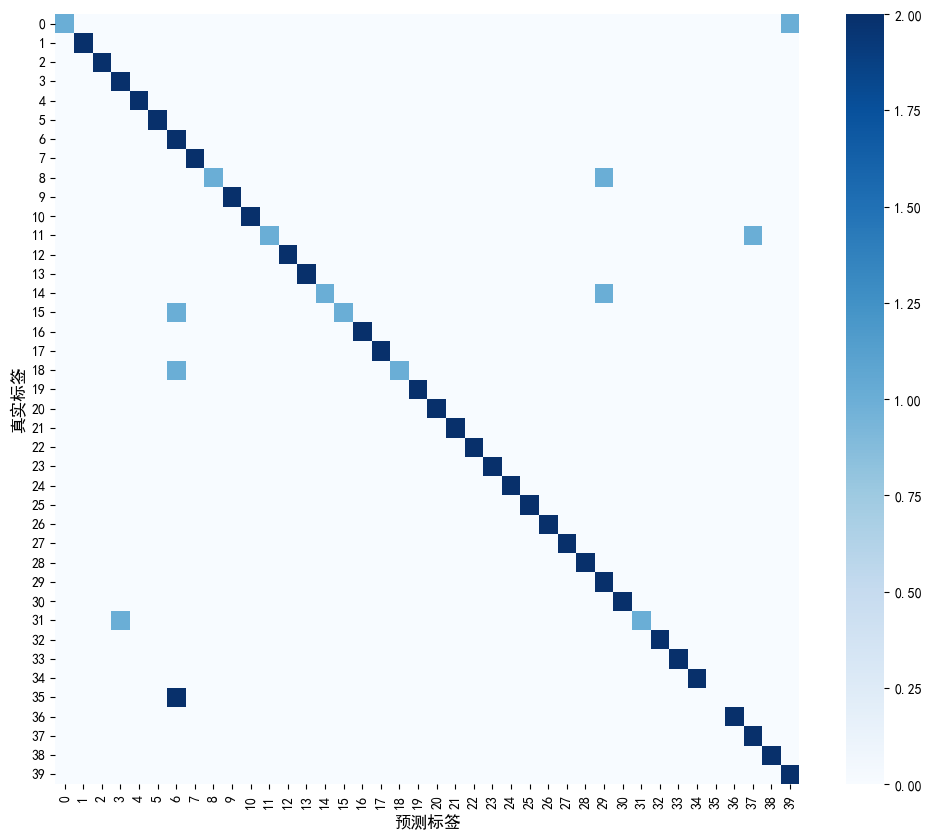

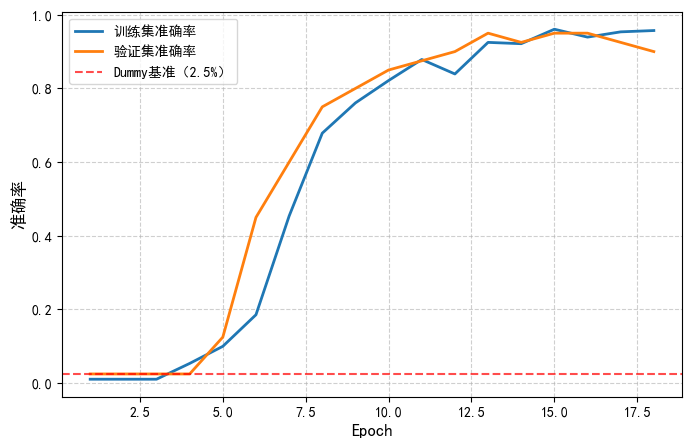

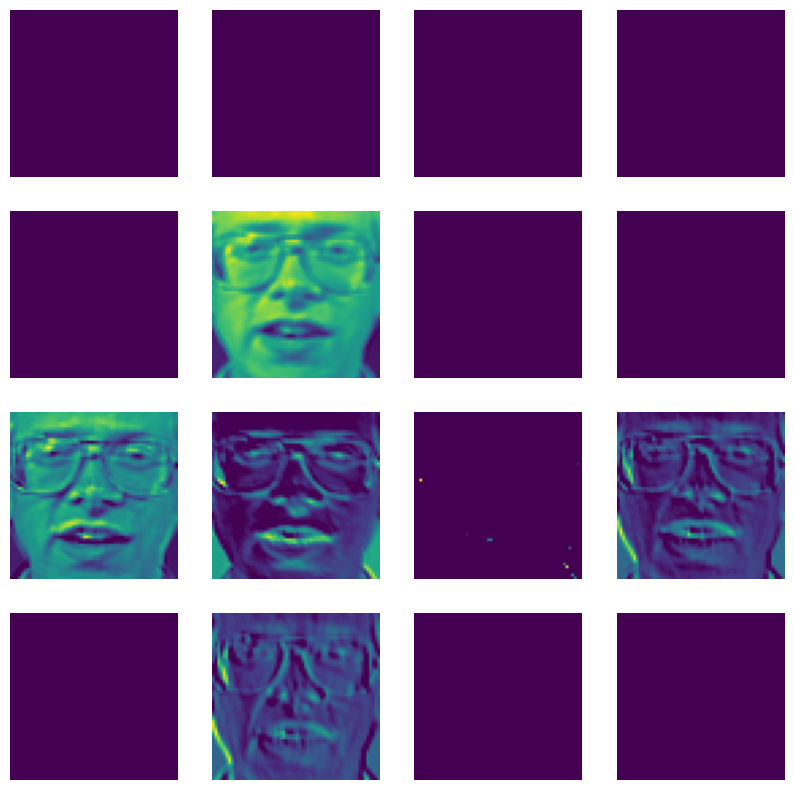

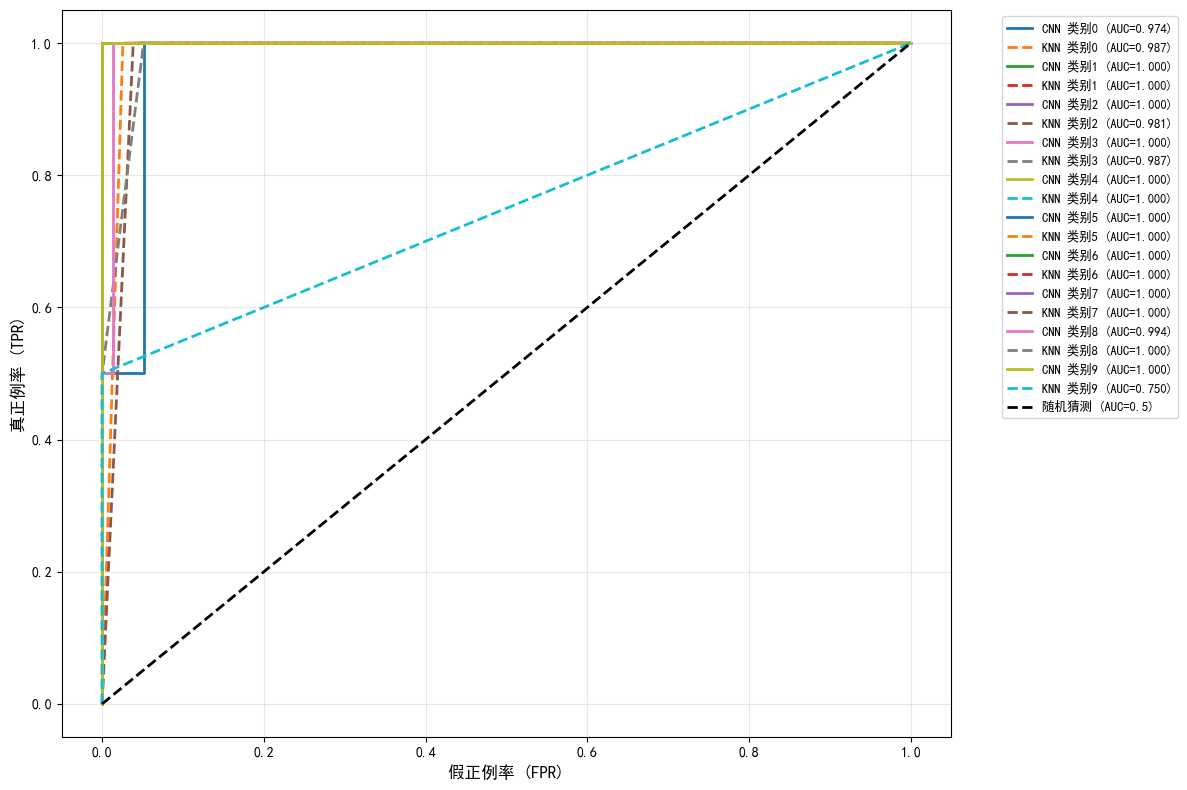

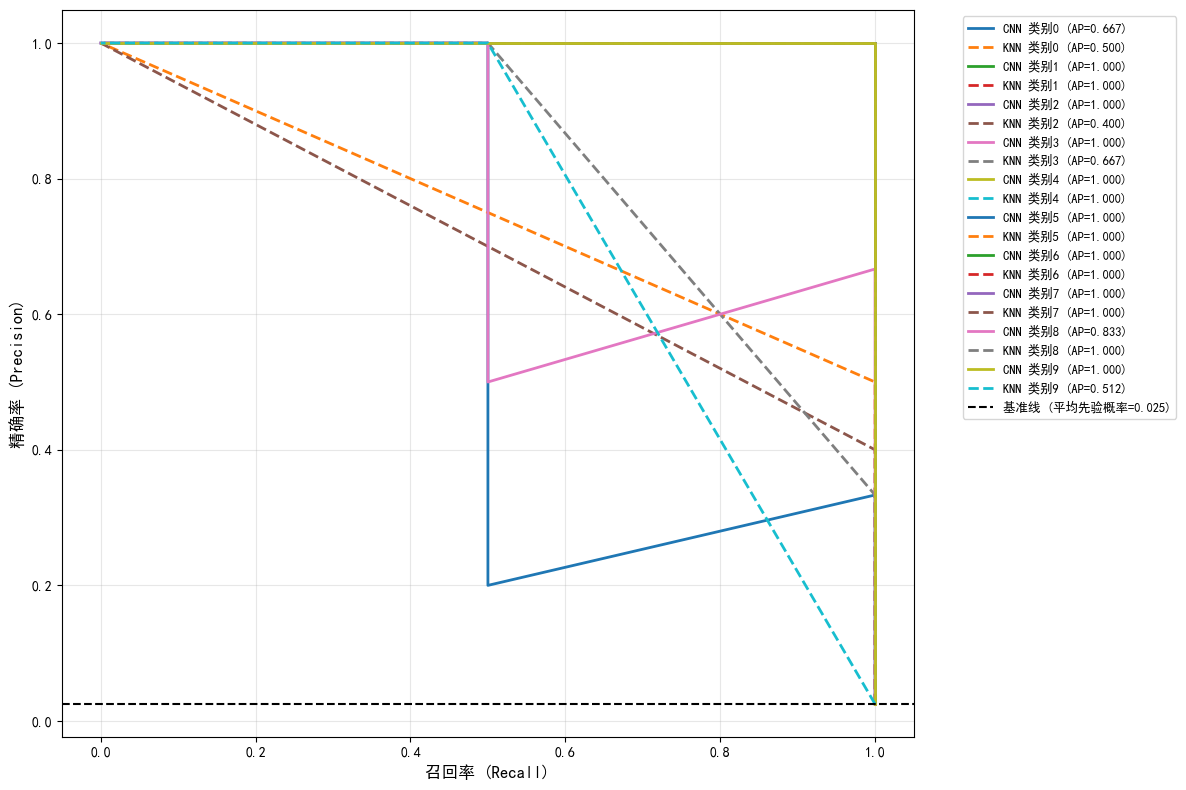

所有可视化图表已保存到： D:\Users\26097\Desktop\homework


In [15]:
with np.load(f"{BASE_PATH}/olivetti_correct_preprocessed.npz", allow_pickle=True) as data:
    x_test_cnn = data["x_test_cnn"]
    y_test = data["y_test"]

with np.load(f"{BASE_PATH}/olivetti_cnn_final_complete_results.npz", allow_pickle=True) as cnn_data:
    cnn_training_hist = cnn_data["training_history"].item()
    cnn_test_results = cnn_data["test_results"].item()
    train_acc_cnn = cnn_training_hist["accuracy"]
    val_acc_cnn = cnn_training_hist["val_accuracy"]
    cm_cnn = cnn_test_results["confusion_matrix"]
    y_pred_cnn = cnn_test_results["y_pred"]
    y_proba_cnn = cnn_test_results["y_pred_proba"]

with np.load(f"{BASE_PATH}/knn_results_olivetti.npz", allow_pickle=True) as knn_data:
    cm_knn = knn_data["confusion_matrix"]
    y_pred_knn = knn_data["y_pred"]
    y_proba_knn = knn_data["y_proba"]

with np.load(f"{BASE_PATH}/dummy_olivetti_results.npz", allow_pickle=True) as dummy_data:
    dummy_test_acc = dummy_data["test_acc"]

# 加载CNN模型
cnn = load_model(f"{BASE_PATH}/cnn_olivetti_final_model_working.h5")
NUM_CLASSES = 40
IMG_SIZE = 64

# 图1：测试集样本示例 
plt.figure(figsize=(10, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    img = x_test_cnn[i].reshape(IMG_SIZE, IMG_SIZE)
    plt.imshow(img, cmap="gray")
    plt.title(f"真实标签: {y_test[i]}", fontsize=12)
    plt.axis("off")
plt.suptitle("图1 Olivetti人脸测试集样本示例", fontsize=14)
plt.savefig(f"{BASE_PATH}/图1_样本示例.png", dpi=300, bbox_inches="tight")
plt.show()

# 图2：KNN混淆矩阵 
plt.figure(figsize=(12, 10))
sns.heatmap(cm_knn, cmap="Blues", cbar=True,
            xticklabels=range(NUM_CLASSES), yticklabels=range(NUM_CLASSES), annot=False)
plt.title("图2 KNN混淆矩阵（40类人脸）", fontsize=14)
plt.xlabel("预测标签", fontsize=12)
plt.ylabel("真实标签", fontsize=12)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.savefig(f"{BASE_PATH}/图2_KNN混淆矩阵.png", dpi=300, bbox_inches="tight")
plt.show()

# 图3：CNN混淆矩阵 
plt.figure(figsize=(12, 10))
sns.heatmap(cm_cnn, cmap="Blues", cbar=True,
            xticklabels=range(NUM_CLASSES), yticklabels=range(NUM_CLASSES), annot=False)
plt.title("图3 CNN混淆矩阵（40类人脸）", fontsize=14)
plt.xlabel("预测标签", fontsize=12)
plt.ylabel("真实标签", fontsize=12)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.savefig(f"{BASE_PATH}/图3_CNN混淆矩阵.png", dpi=300, bbox_inches="tight")
plt.show()

# 图4：CNN学习曲线 
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_acc_cnn)+1), train_acc_cnn, label="训练集准确率", linewidth=2)
plt.plot(range(1, len(val_acc_cnn)+1), val_acc_cnn, label="验证集准确率", linewidth=2)
plt.axhline(y=dummy_test_acc, color='r', linestyle='--', label=f"Dummy基准（{dummy_test_acc:.1%}）", alpha=0.7)
plt.title("图4 CNN学习曲线", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("准确率", fontsize=12)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.savefig(f"{BASE_PATH}/图4_学习曲线.png", dpi=300, bbox_inches="tight")
plt.show()

# 图5：CNN卷积特征可视化
sample_idx = 0
img = x_test_cnn[sample_idx:sample_idx+1]
input_tensor = Input(shape=(IMG_SIZE, IMG_SIZE, 1))
first_conv = cnn.layers[0]
activation_model = Model(inputs=input_tensor, outputs=first_conv(input_tensor))
activations = activation_model.predict(img, verbose=0)[0]

plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(activations[:, :, i], cmap="viridis")
    plt.axis("off")
plt.suptitle("图5 CNN第一层卷积特征可视化（前16个核）", fontsize=14)
plt.savefig(f"{BASE_PATH}/图5_卷积特征.png", dpi=300, bbox_inches="tight")
plt.show()

# 图6：ROC曲线对比（前10类） 
encoder = OneHotEncoder(sparse_output=False)
y_test_onehot = encoder.fit_transform(y_test.reshape(-1, 1))

plt.figure(figsize=(12, 8))
for i in range(min(10, NUM_CLASSES)):
    # CNN ROC
    fpr_cnn, tpr_cnn, _ = roc_curve(y_test_onehot[:, i], y_proba_cnn[:, i])
    auc_cnn = roc_auc_score(y_test_onehot[:, i], y_proba_cnn[:, i])
    plt.plot(fpr_cnn, tpr_cnn, lw=2, label=f'CNN 类别{i} (AUC={auc_cnn:.3f})')
    # KNN ROC
    fpr_knn, tpr_knn, _ = roc_curve(y_test_onehot[:, i], y_proba_knn[:, i])
    auc_knn = roc_auc_score(y_test_onehot[:, i], y_proba_knn[:, i])
    plt.plot(fpr_knn, tpr_knn, lw=2, linestyle='--', label=f'KNN 类别{i} (AUC={auc_knn:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='随机猜测 (AUC=0.5)')
plt.xlabel('假正例率 (FPR)', fontsize=12)
plt.ylabel('真正例率 (TPR)', fontsize=12)
plt.title('图6 ROC曲线对比（前10类）', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{BASE_PATH}/图6_ROC曲线.png", dpi=300, bbox_inches="tight")
plt.show()

# 图7：PR曲线对比（前10类）
baseline = np.mean([np.sum(y_test_onehot[:, i])/len(y_test_onehot) for i in range(10)])
plt.figure(figsize=(12, 8))
for i in range(min(10, NUM_CLASSES)):
    # CNN PR
    prec_cnn, rec_cnn, _ = precision_recall_curve(y_test_onehot[:, i], y_proba_cnn[:, i])
    ap_cnn = average_precision_score(y_test_onehot[:, i], y_proba_cnn[:, i])
    plt.plot(rec_cnn, prec_cnn, lw=2, label=f'CNN 类别{i} (AP={ap_cnn:.3f})')
    # KNN PR
    prec_knn, rec_knn, _ = precision_recall_curve(y_test_onehot[:, i], y_proba_knn[:, i])
    ap_knn = average_precision_score(y_test_onehot[:, i], y_proba_knn[:, i])
    plt.plot(rec_knn, prec_knn, lw=2, linestyle='--', label=f'KNN 类别{i} (AP={ap_knn:.3f})')

plt.axhline(y=baseline, color='k', linestyle='--', label=f'基准线 (平均先验概率={baseline:.3f})')
plt.xlabel('召回率 (Recall)', fontsize=12)
plt.ylabel('精确率 (Precision)', fontsize=12)
plt.title('图7 PR曲线对比（前10类）', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{BASE_PATH}/图7_PR曲线.png", dpi=300, bbox_inches="tight")
plt.show()

组别S0_Baseline（seed=42）：准确率=0.9375，F1=0.9342
组别S0_Baseline（seed=43）：准确率=0.9000，F1=0.8858
组别S0_Baseline（seed=44）：准确率=0.9375，F1=0.9333
组别S1_1Conv（seed=42）：准确率=0.9125，F1=0.9092
组别S1_1Conv（seed=43）：准确率=0.7000，F1=0.6868
组别S1_1Conv（seed=44）：准确率=0.6750，F1=0.6423
组别S2_NoDropout（seed=42）：准确率=0.9125，F1=0.9108
组别S2_NoDropout（seed=43）：准确率=0.8625，F1=0.8518
组别S2_NoDropout（seed=44）：准确率=0.8750，F1=0.8735
组别S3_FC32（seed=42）：准确率=0.4125，F1=0.3472
组别S3_FC32（seed=43）：准确率=0.8875，F1=0.8750
组别S3_FC32（seed=44）：准确率=0.9125，F1=0.8908
组别S4_LR0.001（seed=42）：准确率=0.9625，F1=0.9600
组别S4_LR0.001（seed=43）：准确率=0.8250，F1=0.7976
组别S4_LR0.001（seed=44）：准确率=0.9125，F1=0.9067
组别S5_MildAug（seed=42）：准确率=0.9125，F1=0.9043
组别S5_MildAug（seed=43）：准确率=0.8875，F1=0.8792
组别S5_MildAug（seed=44）：准确率=0.8625，F1=0.8575


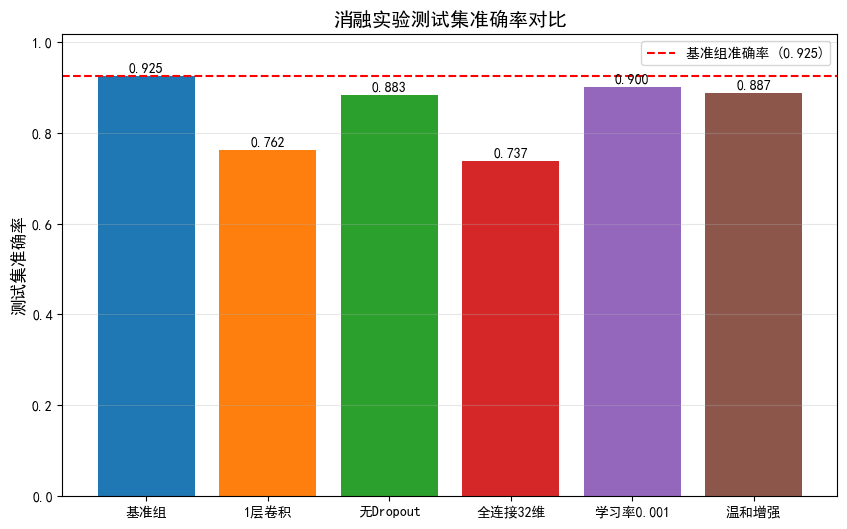

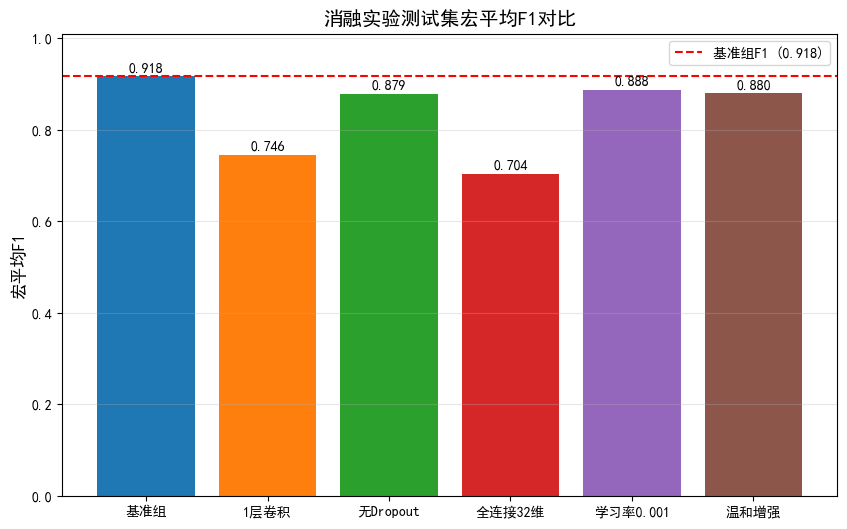


消融实验完成！结果已保存到： D:\Users\26097\Desktop\homework/ablation_experiment_results.csv


In [16]:
with np.load(f"{BASE_PATH}/olivetti_correct_preprocessed.npz", allow_pickle=True) as data:
    x_train = data["x_train_cnn"]
    x_val = data["x_val_cnn"]
    x_test = data["x_test_cnn"]
    y_train = data["y_train"]
    y_val = data["y_val"]
    y_test = data["y_test"]

# 实验配置
SEEDS = [42, 43, 44]
EPOCHS = 20
BATCH_SIZE = 8
PATIENCE = 5

# 通用组件
def get_early_stopping():
    return EarlyStopping(monitor='val_accuracy', patience=PATIENCE, restore_best_weights=True, verbose=0)

def get_mild_datagen():
    return ImageDataGenerator(horizontal_flip=True, rotation_range=5, zoom_range=0.05)

# 定义所有消融组模型 
# 基准组（S0）：2层卷积+Dropout0.2+全连接64+学习率0.001
def build_model_S0(learning_rate=0.001):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.2, seed=42),
        Dense(40, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                  loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

# 消融组1（S1）：1层卷积
def build_model_S1(learning_rate=0.001):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.2, seed=42),
        Dense(40, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                  loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

# 消融组2（S2）：无Dropout
def build_model_S2(learning_rate=0.001):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(40, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                  loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

# 消融组3（S3）：全连接32维
def build_model_S3(learning_rate=0.001):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(32, activation='relu'),
        Dropout(0.2, seed=42),
        Dense(40, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                  loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

# 消融组4（S4）：学习率0.002
def build_model_S4(learning_rate=0.002):
    return build_model_S0(learning_rate=learning_rate)

# 增强组5（S5）：温和数据增强
def build_model_S5(learning_rate=0.001):
    return build_model_S0(learning_rate=learning_rate)

# 实验运行函数 
def run_experiment(model_name, build_func, use_datagen=False, learning_rate=0.001):
    results = []
    for seed in SEEDS:
        np.random.seed(seed)
        tf.random.set_seed(seed)
        
        model = build_func(learning_rate=learning_rate)
        
        if use_datagen:
            datagen = get_mild_datagen()
            datagen.fit(x_train)
            train_gen = datagen.flow(x_train, y_train, batch_size=BATCH_SIZE)
            history = model.fit(train_gen, epochs=EPOCHS, validation_data=(x_val, y_val),
                               callbacks=[get_early_stopping()], verbose=0)
        else:
            history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                               validation_data=(x_val, y_val), callbacks=[get_early_stopping()], verbose=0)
        
        y_pred = np.argmax(model.predict(x_test, verbose=0), axis=1)
        test_acc = accuracy_score(y_test, y_pred)
        test_f1 = f1_score(y_test, y_pred, average="macro")
        
        results.append({
            "model_name": model_name, "seed": seed,
            "test_acc": test_acc, "test_f1": test_f1,
            "best_val_acc": max(history.history["val_accuracy"])
        })
        print(f"组别{model_name}（seed={seed}）：准确率={test_acc:.4f}，F1={test_f1:.4f}")
    
    # 计算平均值
    avg_result = pd.DataFrame(results).agg({
        "test_acc": "mean", "test_f1": "mean", "best_val_acc": "mean"
    }).to_dict()
    avg_result["model_name"] = model_name + "_avg"
    results.append(avg_result)
    return results

# 运行所有消融组 
all_results = []
all_results.extend(run_experiment("S0_Baseline", build_model_S0))
all_results.extend(run_experiment("S1_1Conv", build_model_S1))
all_results.extend(run_experiment("S2_NoDropout", build_model_S2))
all_results.extend(run_experiment("S3_FC32", build_model_S3))
all_results.extend(run_experiment("S4_LR0.001", build_model_S4, learning_rate=0.001))
all_results.extend(run_experiment("S5_MildAug", build_model_S5, use_datagen=True))

# 保存并可视化消融结果
results_df = pd.DataFrame(all_results)
results_df.to_csv(f"{BASE_PATH}/ablation_experiment_results.csv", index=False, encoding="utf-8-sig")

# 简化组别名称
avg_df = results_df[results_df["model_name"].str.endswith("_avg")].copy()
avg_df["model_short"] = avg_df["model_name"].map({
    "S0_Baseline_avg": "基准组", "S1_1Conv_avg": "1层卷积",
    "S2_NoDropout_avg": "无Dropout", "S3_FC32_avg": "全连接32维",
    "S4_LR0.001_avg": "学习率0.001", "S5_MildAug_avg": "温和增强"
})

# 准确率对比图
plt.figure(figsize=(10, 6))
bars = plt.bar(avg_df["model_short"], avg_df["test_acc"], 
               color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b'])
baseline_acc = avg_df[avg_df["model_short"]=="基准组"]["test_acc"].values[0]
plt.axhline(y=baseline_acc, color='red', linestyle='--', label=f'基准组准确率 ({baseline_acc:.3f})')

for bar in bars:
    plt.text(bar.get_x()+bar.get_width()/2., bar.get_height()+0.005,
             f'{bar.get_height():.3f}', ha='center', va='bottom', fontsize=10)

plt.title("消融实验测试集准确率对比", fontsize=14)
plt.ylabel("测试集准确率", fontsize=12)
plt.ylim(0, max(avg_df["test_acc"])*1.1)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.savefig(f"{BASE_PATH}/图8_消融准确率.png", dpi=300, bbox_inches="tight")
plt.show()

# F1对比图
plt.figure(figsize=(10, 6))
bars = plt.bar(avg_df["model_short"], avg_df["test_f1"],
               color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b'])
baseline_f1 = avg_df[avg_df["model_short"]=="基准组"]["test_f1"].values[0]
plt.axhline(y=baseline_f1, color='red', linestyle='--', label=f'基准组F1 ({baseline_f1:.3f})')

for bar in bars:
    plt.text(bar.get_x()+bar.get_width()/2., bar.get_height()+0.005,
             f'{bar.get_height():.3f}', ha='center', va='bottom', fontsize=10)

plt.title("消融实验测试集宏平均F1对比", fontsize=14)
plt.ylabel("宏平均F1", fontsize=12)
plt.ylim(0, max(avg_df["test_f1"])*1.1)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.savefig(f"{BASE_PATH}/图9_消融F1.png", dpi=300, bbox_inches="tight")
plt.show()

Olivetti测试集样本总数：80

误判分析结果：
- 误判样本总数：9
- 误判率：0.1125
- 前10个误判样本索引：[ 1 15 18 32 42 46 48 58 75]...


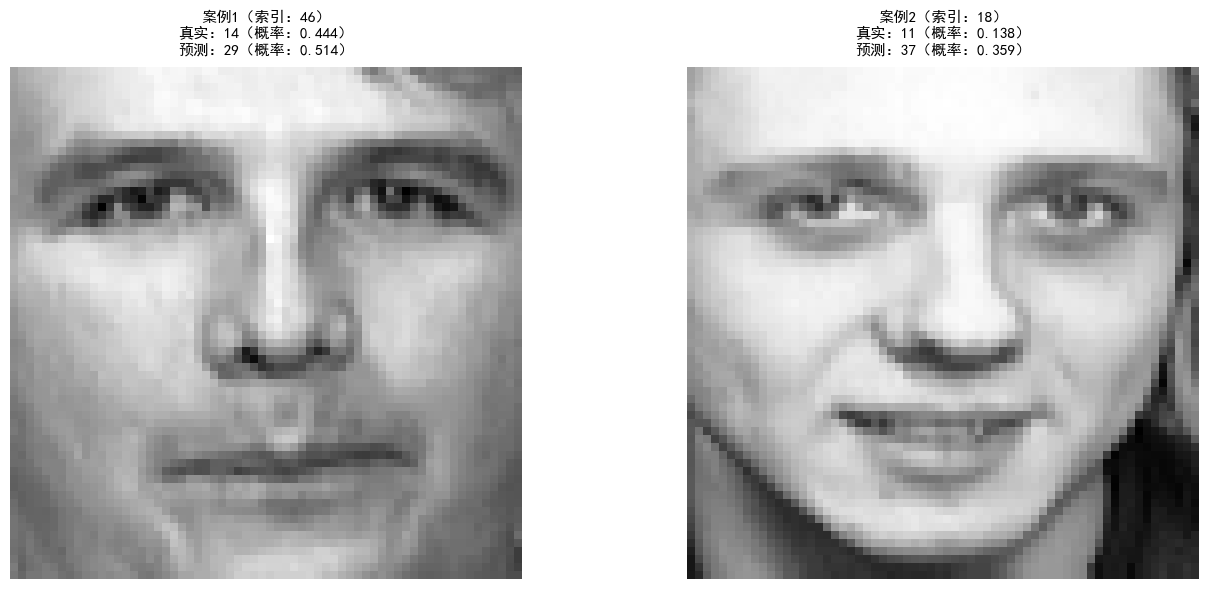


案例1详情：
  索引：46 | 真实→预测：14→29
  概率Top3：[29 14 19]（概率：[0.514 0.444 0.014]）

案例2详情：
  索引：18 | 真实→预测：11→37
  概率Top3：[37  0 11]（概率：[0.359 0.331 0.138]）

误判类别配对统计（真实→预测）：
- 类别35 → 类别6：2次
- 类别11 → 类别37：1次
- 类别15 → 类别6：1次
- 类别8 → 类别29：1次
- 类别14 → 类别29：1次
- 类别31 → 类别3：1次
- 类别18 → 类别6：1次
- 类别0 → 类别39：1次


In [21]:
with np.load(f"{BASE_PATH}/olivetti_correct_preprocessed.npz", allow_pickle=True) as data:
    x_test_cnn = data["x_test_cnn"]
    y_test = data["y_test"]

with np.load(f"{BASE_PATH}/olivetti_cnn_final_complete_results.npz", allow_pickle=True) as cnn_data:
    cnn_test_results = cnn_data["test_results"].item()
    y_pred_cnn = cnn_test_results["y_pred"]
    y_proba_cnn = cnn_test_results["y_pred_proba"]

IMG_SIZE = 64
test_set_size = len(x_test_cnn)

# 误判样本统计
misclassified_idx = np.where(y_pred_cnn != y_test)[0]
misclassified_count = len(misclassified_idx)
misclassified_rate = misclassified_count / test_set_size

print(f"\n误判分析结果：")
print(f"- 误判样本总数：{misclassified_count}")
print(f"- 误判率：{misclassified_rate:.4f}")
if misclassified_count > 0:
    print(f"- 前10个误判样本索引：{misclassified_idx[:10]}...")
else:
    print("\n无任何误判样本")

# 误判样本可视化 
if misclassified_count > 0:
    # 选择2个典型案例
    if len(misclassified_idx) >= 2:
        case1_idx, case2_idx = np.random.choice(misclassified_idx, size=2, replace=False)
    else:
        case1_idx = case2_idx = misclassified_idx[0]

    # 案例1详情
    case1_img = x_test_cnn[case1_idx].reshape(IMG_SIZE, IMG_SIZE)
    case1_true = y_test[case1_idx]
    case1_pred = y_pred_cnn[case1_idx]
    case1_proba = y_proba_cnn[case1_idx]
    case1_top3 = np.argsort(case1_proba)[-3:][::-1]

    # 案例2详情
    case2_img = x_test_cnn[case2_idx].reshape(IMG_SIZE, IMG_SIZE)
    case2_true = y_test[case2_idx]
    case2_pred = y_pred_cnn[case2_idx]
    case2_proba = y_proba_cnn[case2_idx]
    case2_top3 = np.argsort(case2_proba)[-3:][::-1]

    # 可视化
    plt.figure(figsize=(14, 6))
    # 案例1
    plt.subplot(1, 2, 1)
    plt.imshow(case1_img, cmap="gray")
    plt.title(
        f"案例1（索引：{case1_idx}）\n"
        f"真实：{case1_true}（概率：{case1_proba[case1_true]:.3f}）\n"
        f"预测：{case1_pred}（概率：{case1_proba[case1_pred]:.3f}）",
        fontsize=11, pad=10
    )
    plt.axis("off")
    # 案例2
    plt.subplot(1, 2, 2)
    plt.imshow(case2_img, cmap="gray")
    plt.title(
        f"案例2（索引：{case2_idx}）\n"
        f"真实：{case2_true}（概率：{case2_proba[case2_true]:.3f}）\n"
        f"预测：{case2_pred}（概率：{case2_proba[case2_pred]:.3f}）",
        fontsize=11, pad=10
    )
    plt.axis("off")

    plt.suptitle(f"图10 典型误判样本可视化（共{misclassified_count}个，误判率：{misclassified_rate:.4f}）",fontsize=13, y=1.02)
    plt.tight_layout()
    plt.savefig(f"{BASE_PATH}/图10_误判样本可视化.png", dpi=300, bbox_inches="tight")
    plt.show()

    print(f"案例1详情：")
    print(f"  索引：{case1_idx} | 真实→预测：{case1_true}→{case1_pred}")
    print(f"  概率Top3：{case1_top3}（概率：{case1_proba[case1_top3].round(3)}）")
    print(f"\n案例2详情：")
    print(f"  索引：{case2_idx} | 真实→预测：{case2_true}→{case2_pred}")
    print(f"  概率Top3：{case2_top3}（概率：{case2_proba[case2_top3].round(3)}）")

# 误判类别统计 
if misclassified_count > 0:
    misclassified_pairs = list(zip(y_test[misclassified_idx], y_pred_cnn[misclassified_idx]))
    pair_counter = Counter(misclassified_pairs)
    print(f"\n误判类别配对统计（真实→预测）：")
    for (true_cls, pred_cls), count in pair_counter.most_common():
        print(f"- 类别{true_cls} → 类别{pred_cls}：{count}次")